In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def compute_rho(phi_fuz: float, phi_exact: dict, n_extrapol_large=3):
    '''
    n_extrapol_large: the number of largest exact duplicates to use for extrapolation beyond max
                      if 1, this can be quite sensitive to noise, so default is 3
    '''

    lambda_ = None
    max_key = max(phi_exact.keys())
    
    # first if the target is smaller than the smallest for exact
    if phi_fuz <= phi_exact[1]:
        lambda_ = 1
        neq = lambda_ + (phi_fuz - phi_exact[lambda_]) / (phi_exact[lambda_+1] - phi_exact[lambda_])
        neq = max(1.0, neq)
    
    # then if the target is larger than the largest for exact, extrapolate
    elif phi_fuz >= phi_exact[max_key]:
        
        n0 = max_key - n_extrapol_large
        slope = np.mean([np.abs(phi_exact[i + 1] - phi_exact[i]) for i in range(n0, max_key)])
        neq = max_key + (phi_fuz - phi_exact[max_key]) / slope 
        
        #lambda_ = max_key
        #neq = lambda_ + (phi_fuz - phi_exact[lambda_]) / (phi_exact[lambda_] - phi_exact[lambda_ - 1])
    
    # do interpolation otherwise
    else:
        for n in range(1, max_key):
            if phi_exact[n] <= phi_fuz and phi_exact[n+1] >= phi_fuz:
                lambda_ = n
        neq = lambda_ + (phi_fuz - phi_exact[lambda_]) / (phi_exact[lambda_ + 1] - phi_exact[lambda_])
    
    # return the normalized value (assuming n_dup=10)
    return (neq - 1) / 9.0
  
def smooth_curve(nrep_aucs, mia = 'ratio', window_size=3):
    
    original_values =  [np.mean(nrep_aucs[n][mia]) for n in range(1, max(nrep_aucs.keys()) + 1)]

    # Apply a moving average with a window of 3
    smoothed_values = np.convolve(original_values, np.ones(window_size) / window_size, mode='valid')

    # Extend smoothed values to match original length
    smoothed_values = np.concatenate(([original_values[0]], smoothed_values, [original_values[-1]]))
        
    return {n:smoothed_values[i] for i, n in enumerate(range(1,max(nrep_aucs.keys())+1))}

In [3]:
all_ns = [1, 2, 5, 10, 20, 50]

X_insert=1, n=1, mean rho=0.2113, std rho=0.0191
X_insert=1, n=2, mean rho=0.3148, std rho=0.0133
X_insert=1, n=5, mean rho=0.5205, std rho=0.0273
X_insert=1, n=10, mean rho=0.6912, std rho=0.0443
X_insert=1, n=20, mean rho=0.8274, std rho=0.0231
X_insert=1, n=50, mean rho=0.9547, std rho=0.0682
X_insert=5, n=1, mean rho=0.0185, std rho=0.0099
X_insert=5, n=2, mean rho=0.1676, std rho=0.0187
X_insert=5, n=5, mean rho=0.4029, std rho=0.0266
X_insert=5, n=10, mean rho=0.5981, std rho=0.0484
X_insert=5, n=20, mean rho=0.7278, std rho=0.0327
X_insert=5, n=50, mean rho=0.8920, std rho=0.0905
X_insert=10, n=1, mean rho=0.0103, std rho=0.0088
X_insert=10, n=2, mean rho=0.0973, std rho=0.0152
X_insert=10, n=5, mean rho=0.3538, std rho=0.0199
X_insert=10, n=10, mean rho=0.5408, std rho=0.0140
X_insert=10, n=20, mean rho=0.7003, std rho=0.0281
X_insert=10, n=50, mean rho=0.8953, std rho=0.0329
Scrambled results:
n=1, mean rho=0.0634, std rho=0.0088
n=2, mean rho=0.0971, std rho=0.0101
n=5, mean 

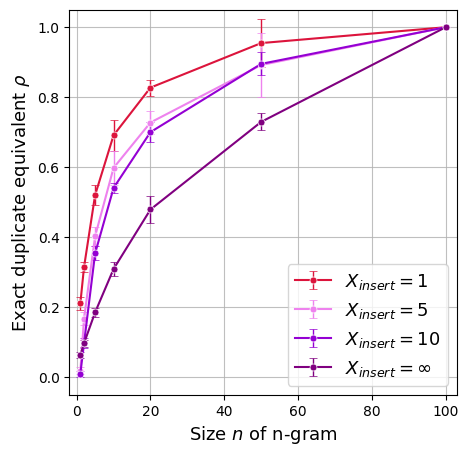

In [ ]:
import matplotlib.pyplot as plt

mia = 'ratio'
colors = ['crimson', 'violet', 'darkviolet']

seeds = (1, 2, 3, 4, 5)

plt.figure(figsize = (5, 5))

# let's start with the ngram insertions
for i, X in enumerate((1, 5, 10)):
    
    all_rhos = {n:[] for n in all_ns}
    
    for seed in seeds:
        exact_path = f"SOME_DATA_DIR/nrep_aucs_gptneo1B_exactduplicates_gpt_seed{seed}_lr2e5.pickle"
         
        with open(exact_path, "rb") as f:
            nrep_aucs = pickle.load(f)
            
        all_phi_exact = smooth_curve(nrep_aucs, mia=mia, window_size=3)
        
        # load the insertion results
        insert_path = f"SOME_DATA_DIR/results_n_gram_insertions_gptneo1B_gpt_seed{seed}_X_insert{X}_lr2e5.pickle"
        
        with open(insert_path, "rb") as f:
            all_insert_results = pickle.load(f)
            
        for n in all_ns:
            all_rhos[n].append(compute_rho(phi_fuz=all_insert_results[n][mia], phi_exact=all_phi_exact))
            
    mean_rhos = [np.mean(all_rhos[n]) for n in all_ns]
    std_rhos = [np.std(all_rhos[n]) for n in all_ns]

    for n in all_ns:
        print(f"X_insert={X}, n={n}, mean rho={mean_rhos[all_ns.index(n)]:.4f}, std rho={np.std(all_rhos[n]):.4f}")
        
    plt.errorbar(all_ns + [100], 
             mean_rhos + [1],
             yerr=std_rhos + [0],
             fmt='-o', 
             color=colors[i], 
             markersize=5,
             markeredgecolor='white', 
             markerfacecolor=colors[i], 
             markeredgewidth=0.5,
             capsize=3,  # adds caps to error bars
             capthick=1,
             elinewidth=1,
             label=f"$X_{{insert}}={X}$")
    
# add scrambled too
all_rhos = {n:[] for n in all_ns}
for seed in seeds:
    exact_path = f"SOME_DATA_DIR/nrep_aucs_gptneo1B_exactduplicates_gpt_seed{seed}_lr2e5.pickle"
     
    with open(exact_path, "rb") as f:
        nrep_aucs = pickle.load(f)
        
    all_phi_exact = smooth_curve(nrep_aucs, mia=mia, window_size=3)
    
    # load the insertion results
    insert_path = f"SOME_DATA_DIR/results_n_gram_scrambled_gptneo1B_gpt_seed{seed}_lr2e5.pickle"
    
    with open(insert_path, "rb") as f:
        all_scramble_results = pickle.load(f)
        
    for n in all_ns:
        all_rhos[n].append(compute_rho(phi_fuz=all_scramble_results[n][mia], phi_exact=all_phi_exact))
    
mean_rhos = [np.mean(all_rhos[n]) for n in all_ns]
std_rhos = [np.std(all_rhos[n]) for n in all_ns]

print("Scrambled results:")
for n in all_ns:
    print(f"n={n}, mean rho={mean_rhos[all_ns.index(n)]:.4f}, std rho={np.std(all_rhos[n]):.4f}")

plt.errorbar(all_ns + [100],
            mean_rhos + [1],
            yerr=std_rhos + [0],
            fmt='-o', 
            color='purple', 
            markersize=5,
            markeredgecolor='white', 
            markerfacecolor='purple', 
            markeredgewidth=0.5,
            capsize=3,  # adds caps to error bars
            capthick=1,
            elinewidth=1,
            label=f"$X_{{insert}}=\infty$")
    
plt.xlabel(r'Size $n$ of n-gram', fontsize = 13)
plt.ylabel(r"Exact duplicate equivalent $\rho$", fontsize = 13)
plt.legend(fontsize = 13, loc='lower right')
plt.grid(alpha = 0.8)
plt.ylim(-0.05, 1.05)
plt.xlim(-2, 103)

plt.show()